# Use Multitask Gaussian Proccess Regression to learn and predict time from SARS-CoV-2 exposure from COVID19 Challenge Study to patient cohort data

-  Instead of using (reduced) gene expression space, we'll fit the model on relative cell type abundances. We can then use Celltypist to provide automated cell type abundances in patients. This will give us predictions per sample instead of per cell.

In [1]:
import math
import torch
import gpytorch
import anndata
import scanpy as sc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import celltypist

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

torch.manual_seed(1)
import random
random.seed(1)
np.random.seed(1)

## Convert single cell data from Challenge Study to cell state frequencies

## Use Celltypist to make training dataset 
Making a training set from celltypist predictions instead of manual annotation, ensures that it's comparible to test data

In [2]:
dfMeta = pd.read_csv("/nfs/team205/rl21/projects/RL007_challengeStudy/df_pbmc_rawGex.obs.withCelltypistPreds.csv", index_col=0, encoding='utf8')

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (28,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# For some reason this becomes neccesary when saving/loading .obs
for i in dfMeta.columns:
    if (dfMeta[i].dtypes=="object"):
        dfMeta[i] = dfMeta[i].astype("string")

In [4]:
%%R -i dfMeta
dfMeta <- dfMeta[dfMeta$covid_status=="Infected",]

In [5]:
%%R -o cell_state_freqs
cell_state_freqs <- as.data.frame.matrix(table(dfMeta$celltypist_prediction,paste0(dfMeta$orig.ident,"_",dfMeta$patient_id,"_",gsub("D","",dfMeta$time_point))))
#head(cell_state_freqs)

In [6]:
%%R -i cell_state_freqs -o cell_state_props -o cell_states
cell_states <- rownames(cell_state_freqs)
cell_state_props <- as.data.frame(t(apply(cell_state_freqs,2,function(x) x/sum(x))))

In [7]:
%%R -o cell_state_props

normaliseCompartments <- TRUE
# used deparse() for this, added some super rare celltypes to bigger ones to prevent 0s

compartment_list <- list(Naive_T = c("T CD8 Naive RTE", "T CD8 Naive", "T CD8 Naive IFN stim", "T CD4 Naive",  "T CD4 Naive IFN stim", "T CD4 Naive RTE"),
                         Naive_B = c("B Naive", "B Naive IFN stim"),
                         B = c("Plasma Cell", "Plasmablast","B Non-Switched Memory", "B Switched Memory",  "B Non-Switched Memory IFN stim", "B Non-Switched FCRL3+",  "B Switched Memory IFN stim", "B Switched FCRL3+"), 
                         "T CD4" = c("T CD4 Helper 0", "T CD4 Follicular Helper", "T CD4 Helper 2",  "T CD4 Helper 0 IFN stim", "T CD4 Helper 2 IFN stim",  "T CD4 Helper 1", "T CD4 Helper 17", "T CD4 Activated CTL",  "T CD4 Helper 1 IFN stim", "T CD4 CTL", "T CD4 Helper 1 Cycling",  "T CD4 Activated CTL Cycling","T Double Negative", "T Double Negative Cycling"), 
                         "T Reg" = c("T Reg CM", "T Reg EM",  "T Reg EM Cycling", "T Reg CM GZMK+ IFNG+", "T Reg CM Cycling" ), 
                         "T CD8" = c("T CD8 EM", "T CD8 EMRA", "NKT",  "T CD8 Activated CTL Cycling", "T CD8 CTL", "T CD8 CM",  "T CD8 CTL Cycling", "T CD8 Activated CTL",  "T CD8 CTL IFN stim", "T CD8 CM IFN stim"), 
                         NK = c("NK", "NK IFN stim",  "NK Cycling","ILC",      "ILC IFN stim","NK CD56+", "NK CD56+ Cycling"), 
                         Monocyte = c("Monocyte CD14+", "Monocyte CD14+ IFN stim",  "Monocyte CD16+", "Monocyte CD14+ Pro-inflammatory", "Monocyte CD16+ IFN stim",  "Monocyte CD16+ C1+"),
                         DC = c("pDC",  "cDC2 IFN stim", "cDC2 CD14+", "cDC2", "pDC IFN stim", "cDC1",  "cDC1 IFN stim", "AS-DC", "cDC1 Cycling","Haematopoietic Progenitor CD34+/CD38-", "Haematopoietic Progenitor CD34+/CD38+",  "Haematopoietic Progenitor CD34+/CD38+ IFN stim", "Lymphoid Progenitor",  "Eosinophil/Basophil/Mast Progenitor", "Myeloid Progenitor"),
                         "T G/D" = c("T G/D non-Dv2/Gv9", "T G/D CM", "T G/D Immature",  "T G/D EM", "T G/D CM IFN stim", "T G/D Immature RTE"), 
                         "T MAI" = c("T MAI Activated",  "T MAI"))

#compartment_list <- list(B = c("Plasma Cell", "Plasmablast","B Non-Switched Memory", "B Naive", "B Switched Memory",  "B Naive IFN stim", "B Non-Switched Memory IFN stim", "B Non-Switched FCRL3+",  "B Switched Memory IFN stim", "B Switched FCRL3+"), 
#                        "T CD4" = c("T CD4 Naive",  "T CD4 Helper 0", "T CD4 Follicular Helper", "T CD4 Helper 2",  "T CD4 Naive IFN stim", "T CD4 Helper 0 IFN stim", "T CD4 Helper 2 IFN stim",  "T CD4 Helper 1", "T CD4 Helper 17", "T CD4 Naive RTE", "T CD4 Activated CTL",  "T CD4 Helper 1 IFN stim", "T CD4 CTL", "T CD4 Helper 1 Cycling",  "T CD4 Activated CTL Cycling","T Double Negative", "T Double Negative Cycling"), 
#                        "T Reg" = c("T Reg CM", "T Reg EM",  "T Reg EM Cycling", "T Reg CM GZMK+ IFNG+", "T Reg CM Cycling" ), 
#                        "T CD8" = c("T CD8 Naive", "T CD8 EM", "T CD8 EMRA", "NKT",  "T CD8 Activated CTL Cycling", "T CD8 CTL", "T CD8 CM", "T CD8 Naive IFN stim",  "T CD8 Naive RTE", "T CD8 CTL Cycling", "T CD8 Activated CTL",  "T CD8 CTL IFN stim", "T CD8 CM IFN stim"), 
#                         NK = c("NK", "NK IFN stim",  "NK Cycling","ILC",      "ILC IFN stim"), 
#                         Monocyte = c("Monocyte CD14+", "Monocyte CD14+ IFN stim",  "Monocyte CD16+", "Monocyte CD14+ Pro-inflammatory", "Monocyte CD16+ IFN stim",  "Monocyte CD16+ C1+"), "NK CD56+" = c("NK CD56+", "NK CD56+ Cycling" ), 
#                         "T G/D" = c("T G/D non-Dv2/Gv9", "T G/D CM", "T G/D Immature",  "T G/D EM", "T G/D CM IFN stim", "T G/D Immature RTE"), 
#                         DC = c("pDC",  "cDC2 IFN stim", "cDC2 CD14+", "cDC2", "pDC IFN stim", "cDC1",  "cDC1 IFN stim", "AS-DC", "cDC1 Cycling","Haematopoietic Progenitor CD34+/CD38-", "Haematopoietic Progenitor CD34+/CD38+",  "Haematopoietic Progenitor CD34+/CD38+ IFN stim", "Lymphoid Progenitor",  "Eosinophil/Basophil/Mast Progenitor", "Myeloid Progenitor"), 
#                         "T MAI" = c("T MAI Activated",  "T MAI"))

if (normaliseCompartments) { for (compartment in names(compartment_list)) { cell_state_props[,compartment_list[[compartment]]] <- as.data.frame(t(apply(cell_state_freqs[compartment_list[[compartment]],],2,function(x) x/sum(x)))) } }
cell_state_props = -log10(cell_state_props+.01)

In [8]:
cell_state_props[np.isnan(cell_state_props)] = 2

In [9]:
y = torch.tensor(cell_state_props.to_numpy(), dtype=torch.get_default_dtype())

In [10]:
%%R -i cell_state_props -o time_numeric
time_numeric <- as.numeric(gsub(".*_(.*)","\\1",rownames(cell_state_props)))
#time_numeric <- log2(time_numeric+3)
time_numeric <- (time_numeric+2)^.5
time_numeric

 [1] 5.477226 3.464102 4.000000 5.477226 3.464102 1.000000 4.000000 5.477226
 [9] 2.236068 5.477226 1.000000 4.000000 4.000000 3.464102 2.236068 3.464102
[17] 2.236068 3.464102 1.000000 5.477226 3.000000 4.000000 3.464102 2.236068
[25] 1.000000 3.000000 1.000000 2.236068 5.477226 1.000000 4.000000 3.464102
[33] 3.464102 5.477226 3.464102 3.000000 1.000000 4.000000 3.464102 1.000000
[41] 4.000000 3.000000 3.464102 3.464102 5.477226 5.477226 1.000000 1.000000
[49] 5.477226 1.000000 3.000000 2.236068 4.000000 4.000000 1.000000 4.000000
[57] 4.000000


## Use GPLVM to smooth time
Created a latent variable of time to smooth time based on the same y in RL007_GplvmToSmoothTime.ipynb

In [11]:
%%R -o time_numeric
smoothTimeTable <- structure(list(sample_id = c("COV19_CH11286513+COV19_CH11408323_666427_28",  "COV19_CH11286513+COV19_CH11408323_676586_10", "COV19_CH11286514+COV19_CH11408324_635779_14",  "COV19_CH11286514+COV19_CH11408324_651806_28", "COV19_CH11286515+COV19_CH11408325_651806_10",  "COV19_CH11286515+COV19_CH11408325_666427_-1", "COV19_CH11286515+COV19_CH11408325_676586_14",  "COV19_CH11286516+COV19_CH11408326_635779_28", "COV19_CH11286516+COV19_CH11408326_666427_3",  "COV19_CH11286517+COV19_CH11408327_651806_28", "COV19_CH11286517+COV19_CH11408327_666427_-1",  "COV19_CH11286518+COV19_CH11408328_635779_14", "COV19_CH11286518+COV19_CH11408328_676586_14",  "COV19_CH11286519+COV19_CH11408329_651806_10", "COV19_CH11286519+COV19_CH11408329_666427_3",  "COV19_CH11286519+COV19_CH11408329_676586_10", "COV19_CH11286520+COV19_CH11408290_635779_3",  "COV19_CH11286520+COV19_CH11408290_666427_10", "COV19_CH11286521+COV19_CH11408291_651806_-1",  "COV19_CH11286521+COV19_CH11408291_676586_28", "COV19_CH11286522+COV19_CH11408292_635779_7",  "COV19_CH11286522+COV19_CH11408292_666427_14", "COV19_CH11286523+COV19_CH11408293_635779_10",  "COV19_CH11286523+COV19_CH11408293_651806_3", "COV19_CH11286523+COV19_CH11408293_676586_-1",  "COV19_CH11286524+COV19_CH11408294_635779_7", "COV19_CH11286524+COV19_CH11408294_676586_-1",  "COV19_CH11286525+COV19_CH11408295_651806_3", "COV19_CH11286525+COV19_CH11408295_676586_28",  "COV19_CH11286526+COV19_CH11408296_651806_-1", "COV19_CH11286526+COV19_CH11408296_666427_14",  "COV19_CH11286527+COV19_CH11408297_635779_10", "COV19_CH11286527+COV19_CH11408297_666427_10",  "COV19_CH11286528+COV19_CH11408298_666427_28", "COV19_CH11286529+COV19_CH11408299_673353_10",  "COV19_CH11286529+COV19_CH11408299_674700_7", "COV19_CH11286530+COV19_CH11408300_674700_-1",  "COV19_CH11286531+COV19_CH11408301_673353_14", "COV19_CH11286531+COV19_CH11408301_674700_10",  "COV19_CH11286533+COV19_CH11408303_674700_-1", "COV19_CH11286534+COV19_CH11408304_673353_14",  "COV19_CH11286534+COV19_CH11408304_674700_7", "COV19_CH11286535+COV19_CH11408305_673353_10",  "COV19_CH11286535+COV19_CH11408305_674700_10", "COV19_CH11286537+COV19_CH11408307_673353_28",  "COV19_CH11286538+COV19_CH11408308_674700_28", "COV19_CH11286539+COV19_CH11408309_673353_-1",  "COV19_CH11286541+COV19_CH11408311_673353_-1", "COV19_CH11286544+COV19_CH11408314_674700_28",  "COV19_CH11286545+COV19_CH11408315_635779_-1", "COV19_CH11286545+COV19_CH11408315_666427_7",  "COV19_CH11286545+COV19_CH11408315_674700_3", "COV19_CH11286546+COV19_CH11408316_651806_14",  "COV19_CH11286547+COV19_CH11408317_674700_14", "COV19_CH11286550+COV19_CH11408320_635779_-1",  "COV19_CH11286552+COV19_CH11408322_651806_14", "COV19_CH11286552+COV19_CH11408322_674700_14" ), predicted_time = c(28.4614880113595, 10.6773565275599, 15.4205625850673,  26.3512557854638, 10.3931879558837, -1.07384207432118, 14.920326170077,  26.7603923009212, 2.89895225058632, 26.6681355463807, -1.55186393052189,  14.7623771263209, 14.6167321270914, 11.619508843508, 2.94585563665737,  10.0799246585421, 5.80718825708959, 11.1745174632447, -1.39969373049684,  26.9278209645354, 8.04986942588317, 14.5653438861066, 10.5828254871922,  3.41645657429422, -1.27067590283626, 7.78379647070375, -0.92494262253598,  2.90143805919274, 24.0423724131763, -1.29571271399981, 12.9404975490781,  9.29517233965322, 10.3311571909735, 26.11326752682, 9.27196466214286,  8.09623358543428, -0.988687650721602, 12.9554415807515, 9.81617677323175,  -1.33246302987128, 13.7857031687317, 7.44715066132267, 10.5355229571142,  10.4046978113004, 34.2819429264894, 28.3744496726367, -1.05599819636562,  -1.16229277318419, 27.8046962523986, -1.0782133786149, 7.49207968212301,  2.21267505675337, 13.0216400089385, 13.538353930042, -1.14037550449063,  13.4411247058306, 13.2464385000385), real_time = c(28.0000022504321,  9.99999956924245, 14, 28.0000022504321, 9.99999956924245, -1,  14, 28.0000022504321, 3.00000014682206, 28.0000022504321, -1,  14, 14, 9.99999956924245, 3.00000014682206, 9.99999956924245,  3.00000014682206, 9.99999956924245, -1, 28.0000022504321, 7,  14, 9.99999956924245, 3.00000014682206, -1, 7, -1, 3.00000014682206,  28.0000022504321, -1, 14, 9.99999956924245, 9.99999956924245,  28.0000022504321, 9.99999956924245, 7, -1, 14, 9.99999956924245,  -1, 14, 7, 9.99999956924245, 9.99999956924245, 28.0000022504321,  28.0000022504321, -1, -1, 28.0000022504321, -1, 7, 3.00000014682206,  14, 14, -1, 14, 14), patient_id = c("COV19_CH11286513+COV19_CH11408323_666427",  "COV19_CH11286513+COV19_CH11408323_676586", "COV19_CH11286514+COV19_CH11408324_635779",  "COV19_CH11286514+COV19_CH11408324_651806", "COV19_CH11286515+COV19_CH11408325_651806",  "COV19_CH11286515+COV19_CH11408325_666427", "COV19_CH11286515+COV19_CH11408325_676586",  "COV19_CH11286516+COV19_CH11408326_635779", "COV19_CH11286516+COV19_CH11408326_666427",  "COV19_CH11286517+COV19_CH11408327_651806", "COV19_CH11286517+COV19_CH11408327_666427",  "COV19_CH11286518+COV19_CH11408328_635779", "COV19_CH11286518+COV19_CH11408328_676586",  "COV19_CH11286519+COV19_CH11408329_651806", "COV19_CH11286519+COV19_CH11408329_666427",  "COV19_CH11286519+COV19_CH11408329_676586", "COV19_CH11286520+COV19_CH11408290_635779",  "COV19_CH11286520+COV19_CH11408290_666427", "COV19_CH11286521+COV19_CH11408291_651806",  "COV19_CH11286521+COV19_CH11408291_676586", "COV19_CH11286522+COV19_CH11408292_635779",  "COV19_CH11286522+COV19_CH11408292_666427", "COV19_CH11286523+COV19_CH11408293_635779",  "COV19_CH11286523+COV19_CH11408293_651806", "COV19_CH11286523+COV19_CH11408293_676586",  "COV19_CH11286524+COV19_CH11408294_635779", "COV19_CH11286524+COV19_CH11408294_676586",  "COV19_CH11286525+COV19_CH11408295_651806", "COV19_CH11286525+COV19_CH11408295_676586",  "COV19_CH11286526+COV19_CH11408296_651806", "COV19_CH11286526+COV19_CH11408296_666427",  "COV19_CH11286527+COV19_CH11408297_635779", "COV19_CH11286527+COV19_CH11408297_666427",  "COV19_CH11286528+COV19_CH11408298_666427", "COV19_CH11286529+COV19_CH11408299_673353",  "COV19_CH11286529+COV19_CH11408299_674700", "COV19_CH11286530+COV19_CH11408300_674700",  "COV19_CH11286531+COV19_CH11408301_673353", "COV19_CH11286531+COV19_CH11408301_674700",  "COV19_CH11286533+COV19_CH11408303_674700", "COV19_CH11286534+COV19_CH11408304_673353",  "COV19_CH11286534+COV19_CH11408304_674700", "COV19_CH11286535+COV19_CH11408305_673353",  "COV19_CH11286535+COV19_CH11408305_674700", "COV19_CH11286537+COV19_CH11408307_673353",  "COV19_CH11286538+COV19_CH11408308_674700", "COV19_CH11286539+COV19_CH11408309_673353",  "COV19_CH11286541+COV19_CH11408311_673353", "COV19_CH11286544+COV19_CH11408314_674700",  "COV19_CH11286545+COV19_CH11408315_635779", "COV19_CH11286545+COV19_CH11408315_666427",  "COV19_CH11286545+COV19_CH11408315_674700", "COV19_CH11286546+COV19_CH11408316_651806",  "COV19_CH11286547+COV19_CH11408317_674700", "COV19_CH11286550+COV19_CH11408320_635779",  "COV19_CH11286552+COV19_CH11408322_651806", "COV19_CH11286552+COV19_CH11408322_674700" )), row.names = c(NA, -57L), class = "data.frame")
time_numeric <- (smoothTimeTable$predicted_time+2)^.5
time_numeric

 [1] 5.5191927 3.5605276 4.1737947 5.3245897 3.5203960 0.9623710 4.1134324
 [8] 5.3628716 2.2133577 5.3542633 0.6694297 4.0941882 4.0763626 3.6904619
[15] 2.2239280 3.4756186 2.7941346 3.6296718 0.7747943 5.3784590 3.1701529
[22] 4.0700545 3.5472279 2.3273282 0.8540047 3.1279061 1.0368497 2.2139192
[29] 5.1031728 0.8392183 3.8652940 3.3608291 3.5115747 5.3021946 3.3573747
[36] 3.1774571 1.0056403 3.8672266 3.4374666 0.8170294 3.9731226 3.0736217
[43] 3.5405540 3.5220304 6.0234494 5.5113020 0.9715976 0.9152635 5.4593678
[50] 0.9600972 3.0809219 2.0524802 3.8757761 3.9418719 0.9271594 3.9295197
[57] 3.9046688


In [12]:
time_numeric = torch.tensor(time_numeric, dtype=torch.float32)

## Build MTGPR

In [13]:
train_y = y
train_x = time_numeric

### Define a multitask model

In [14]:
# Define number of tasks as the amount of variables (cell states)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=train_y.size(1)
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=train_y.size(1), rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks = train_y.size(1))
model = MultitaskGPModel(train_x, train_y, likelihood)

### Train the model hyperparameters

In [15]:
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 100
loss_list = list()

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    loss_list.append(loss.item())
    optimizer.step()
    if loss.item()<0:
        break

Iter 1/100 - Loss: 1.306
Iter 2/100 - Loss: 1.252
Iter 3/100 - Loss: 1.200
Iter 4/100 - Loss: 1.151
Iter 5/100 - Loss: 1.103
Iter 6/100 - Loss: 1.058
Iter 7/100 - Loss: 1.014
Iter 8/100 - Loss: 0.972
Iter 9/100 - Loss: 0.932
Iter 10/100 - Loss: 0.892
Iter 11/100 - Loss: 0.853
Iter 12/100 - Loss: 0.815
Iter 13/100 - Loss: 0.778
Iter 14/100 - Loss: 0.741
Iter 15/100 - Loss: 0.705
Iter 16/100 - Loss: 0.670
Iter 17/100 - Loss: 0.635
Iter 18/100 - Loss: 0.601
Iter 19/100 - Loss: 0.567
Iter 20/100 - Loss: 0.534
Iter 21/100 - Loss: 0.502
Iter 22/100 - Loss: 0.472
Iter 23/100 - Loss: 0.442
Iter 24/100 - Loss: 0.413
Iter 25/100 - Loss: 0.385
Iter 26/100 - Loss: 0.358
Iter 27/100 - Loss: 0.333
Iter 28/100 - Loss: 0.309
Iter 29/100 - Loss: 0.286
Iter 30/100 - Loss: 0.266
Iter 31/100 - Loss: 0.246
Iter 32/100 - Loss: 0.229
Iter 33/100 - Loss: 0.213
Iter 34/100 - Loss: 0.199
Iter 35/100 - Loss: 0.186
Iter 36/100 - Loss: 0.174
Iter 37/100 - Loss: 0.163
Iter 38/100 - Loss: 0.154
Iter 39/100 - Loss: 0

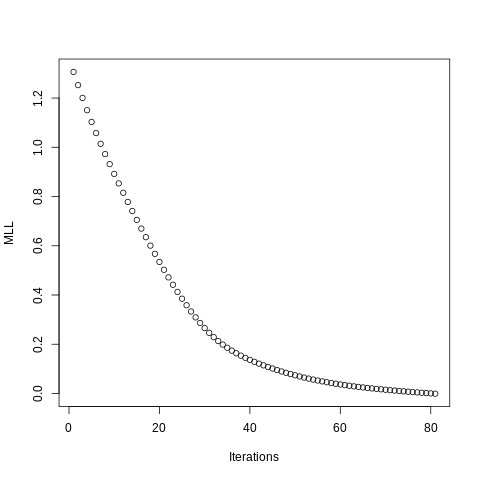

In [16]:
%%R -i loss_list
plot(unlist(loss_list),xlab="Iterations",ylab="MLL")

### Make predictions with the model

We've normalised the relative abundance with -log10(fraction+0.01), so the dynamic range of fractions is between 0-2 (1-0.01)

In [17]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-1, 28, 300)+2 # This is better but slower..
    test_x = test_x.sqrt()
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

None

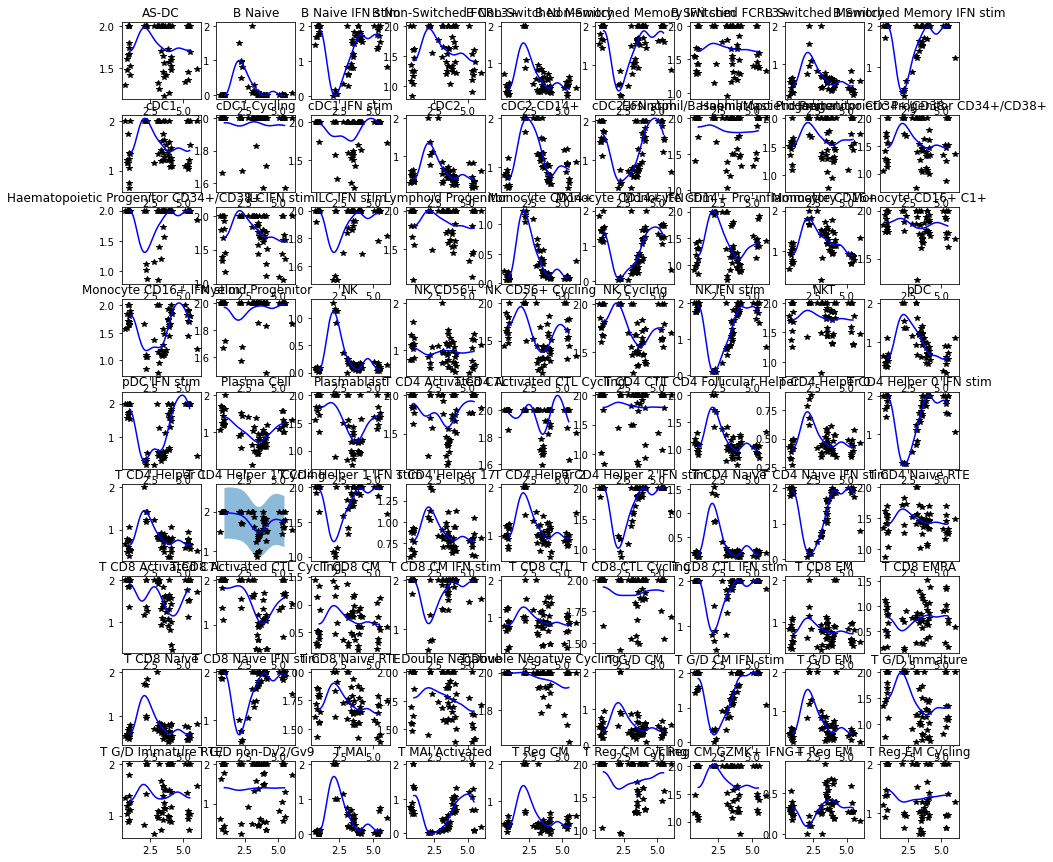

In [18]:
fig, axs = plt.subplots(nrows=9, ncols=9, figsize=(15, 15))

for var_number in range(0,len(cell_states)):
    my_cell_state = cell_states[var_number]
    myPlot = axs.ravel()[var_number]
    myPlot.plot(train_x.detach().numpy(), train_y[:, var_number].detach().numpy(), 'k*')
    myPlot.plot(test_x.numpy(), mean[:, var_number].numpy(), 'b')
    # Shade in confidence
    myPlot.fill_between(test_x.numpy(), lower[:, var_number].numpy(), upper[:, var_number].numpy(), alpha=0.5)
    #myPlot.set_ylim([0, .1])
    #myPlot.legend(['Observed Data', 'Mean', 'Confidence'])
    myPlot.set_title(my_cell_state)

In [19]:
preds = mean.detach().numpy()

In [20]:
test_x_np = test_x.detach().numpy()

Because some cell compartments behave very similar over time, we have the option to weigh these clusters of similar cell types equally regardless of the size of each cluster. This is optional and was not used in the paper.

R[write to console]: Loading required package: grid

R[write to console]: ========================================
ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




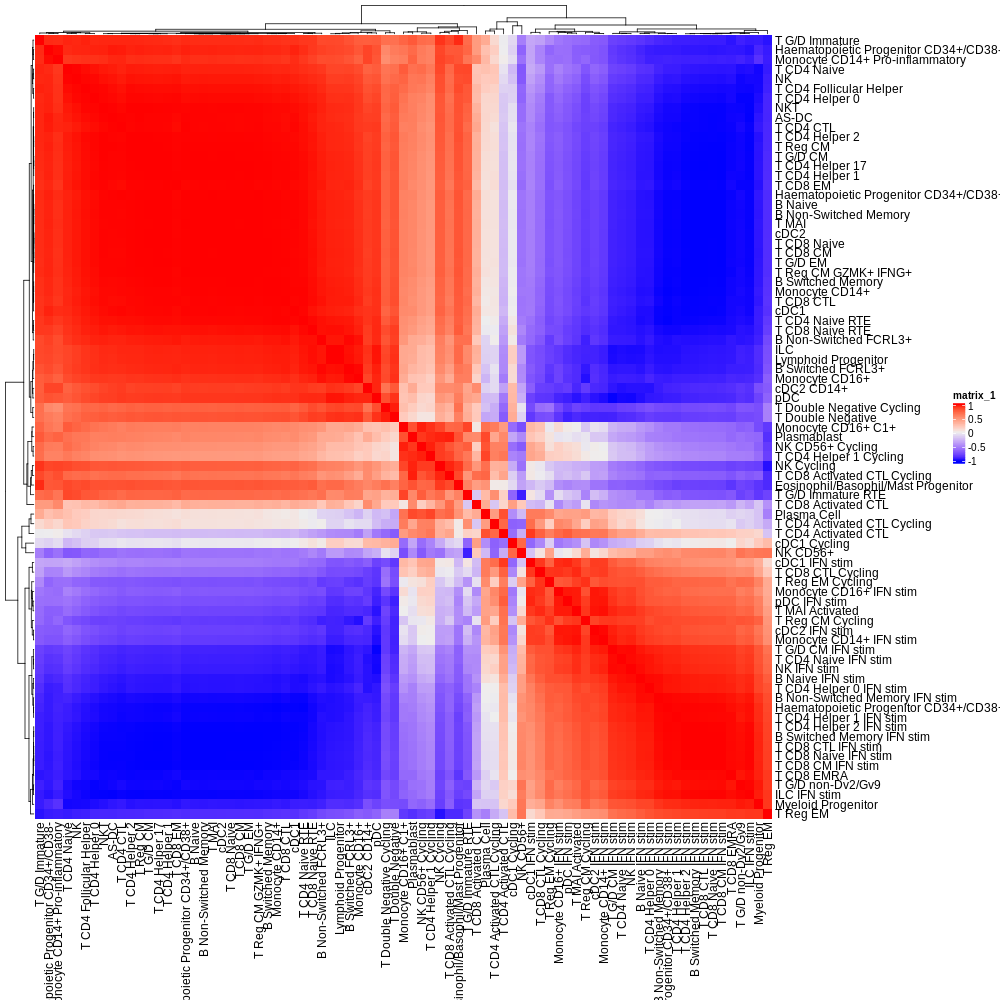

In [21]:
%%R -i preds -w 1000 -h 1000
library(ComplexHeatmap)
colnames(preds) <- colnames(cell_state_props)
myCor <- as.data.frame(cor((preds)))
Heatmap(myCor)


In [22]:
%%R
library(factoextra)
library(cluster)
fviz_nbclust(myCor, kmeans, method = "wss",k.max=25)

R[write to console]: Error in library(factoextra) : there is no package called ‘factoextra’

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: The input is a data frame, convert it to the matrix. 




Error in library(factoextra) : there is no package called ‘factoextra’


In [23]:
%%R
myKm <- kmeans(myCor,centers=3)$cluster
myWeights <- myKm
for (i in unique(myKm)) {
    myWeights[myKm==i] <- 1/sum(myKm==i)
}
myWeights[order(myWeights,decreasing=T)]

                                  cDC1 Cycling 
                                    0.11111111 
                            Monocyte CD16+ C1+ 
                                    0.11111111 
                              NK CD56+ Cycling 
                                    0.11111111 
                                   Plasma Cell 
                                    0.11111111 
                                   Plasmablast 
                                    0.11111111 
                           T CD4 Activated CTL 
                                    0.11111111 
                   T CD4 Activated CTL Cycling 
                                    0.11111111 
                        T CD4 Helper 1 Cycling 
                                    0.11111111 
                           T CD8 Activated CTL 
                                    0.11111111 
                              B Naive IFN stim 
                                    0.03571429 
                B Non-Switched Memory IF

In [24]:
%%R -i preds -i cell_state_props -i test_x_np -o bestFits
train_x <- ((test_x_np^2)-2)
#train_x <- ((2^test_x_np)-3)
colnames(preds) <- colnames(cell_state_props)

preds_corrected <- preds
preds_corrected[preds_corrected>2] <- 2 # Sometimes the model oversmooths and gives negative values with should be corrected
preds_corrected[preds_corrected<0] <- 0 # Sometimes the model oversmooths and gives negative values with should be corrected

#bestFits <- data.frame(samples=rownames(cell_state_props), patient_id = gsub("(.*)_(.*)","\\1",rownames(cell_state_props)), time_point = as.numeric(gsub("(.*)_(.*)","\\2",rownames(cell_state_props))), min_mse=NA, best_pred=NA, stringsAsFactors=F)
bestFits <- data.frame(samples=rownames(cell_state_props), patient_id = gsub(".*_([0-9]*)_(.*)","\\1",rownames(cell_state_props)), time_point = as.numeric(gsub(".*_(.*?)_(.*?)","\\2",rownames(cell_state_props))), min_mse=NA, best_pred=NA, stringsAsFactors=F)

# Selecting known dynamic genes might make the prediction better in patients
#informativeCellStates <- colnames(preds_corrected)[!colnames(preds_corrected)%in%c('AS-DC', 'B Naive', 'B Non-Switched FCRL3+', 'B Switched FCRL3+', 'B Switched Memory', 'cDC1 Cycling', 'cDC1 IFN stim', 'Eosinophil/Basophil/Mast Progenitor', 'Haematopoietic Progenitor CD34+/CD38-', 'Haematopoietic Progenitor CD34+/CD38+', 'ILC', 'ILC IFN stim', 'Lymphoid Progenitor', 'Monocyte CD16+ C1+', 'Myeloid Progenitor', 'NK CD56+', 'NK CD56+ Cycling', 'NK Cycling', 'NKT', 'T CD4 CTL', 'T CD4 Helper 0', 'T CD4 Helper 17', 'T CD4 Naive', 'T CD4 Naive RTE', 'T CD8 CM', 'T CD8 CTL Cycling', 'T CD8 EM', 'T CD8 EMRA', 'T CD8 Naive', 'T CD8 Naive RTE', 'T Double Negative', 'T Double Negative Cycling', 'T G/D CM', 'T G/D Immature', 'T G/D Immature RTE', 'T G/D non-Dv2/Gv9', 'T Reg CM', 'T Reg CM Cycling', 'T Reg CM GZMK+ IFNG+', 'T Reg EM', 'T Reg EM Cycling')]
informativeCellStates <- colnames(preds_corrected)

for (i in bestFits$samples) {
    mySample <- cell_state_props[i,]
    #mses <- apply(preds[,informativeCellStates],1,function(x) mean(as.numeric((x-mySample[,informativeCellStates])^2)))
    mses <- apply(preds_corrected[,informativeCellStates],1,function(x) weighted.mean(as.numeric((x-mySample[,informativeCellStates])^2), w=myWeights[informativeCellStates]))
    bestFits$best_pred[bestFits$samples==i] <- train_x[mses==min(mses)]
    bestFits$min_mse[bestFits$samples==i] <- min(mses)
    #print(i)
}
#print(bestFits)

The model predicts well during the infection, but sometimes cannot distinguish baseline samples from day28 (2 weeks after quarintine has ended in most cases), indicating that at that time the immune system has normalised back to baseline again

[1] 0.06162358


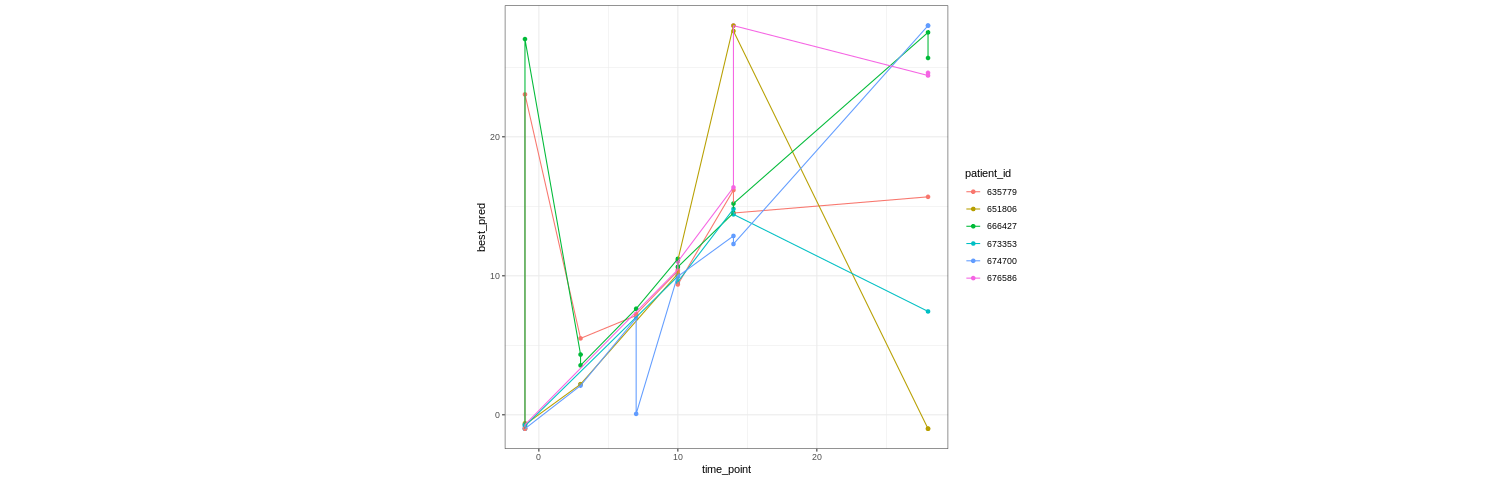

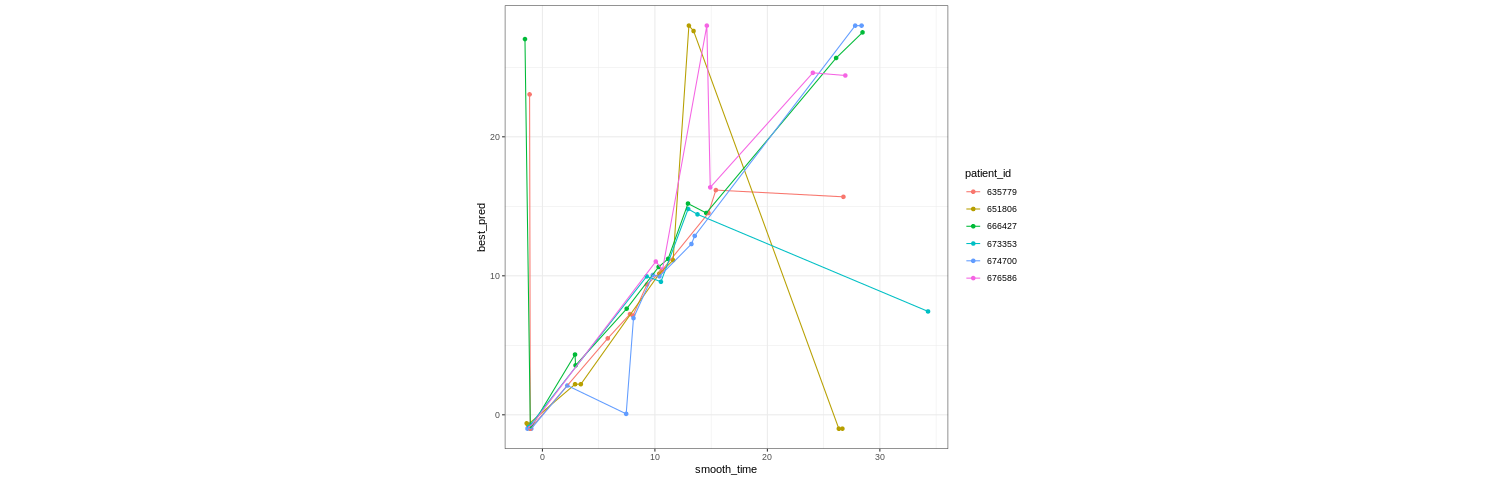

In [25]:
%%R -i bestFits -w 1500
library(ggplot2)
bestFits$smooth_time <- ((time_numeric^2)-2)
print(ggplot(bestFits,aes(time_point,best_pred,col=patient_id)) + geom_point() + geom_line() + theme_bw() + theme(aspect.ratio=1))
print(ggplot(bestFits,aes(smooth_time,best_pred,col=patient_id)) + geom_point() + geom_line() + theme_bw() + theme(aspect.ratio=1))
print(mean(bestFits$min_mse))

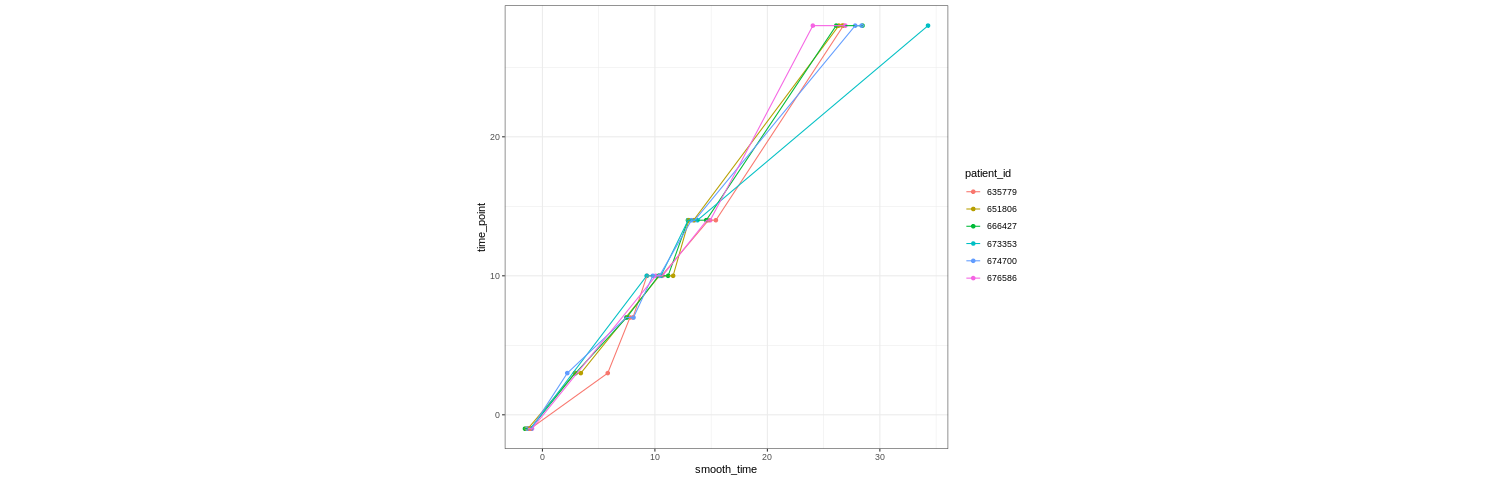

In [26]:
%%R -w 1500
ggplot(bestFits,aes(smooth_time,time_point,col=patient_id)) + geom_point() + geom_line() + theme_bw() + theme(aspect.ratio=1)

## Convert public data with celltypist predictions to input

In [27]:
obs = pd.read_csv('/nfs/team205/rl21/projects/RL007_challengeStudy/adata_public.obs.withCelltypistPreds.csv')

# different ID for COMBAT
def assign_sampleid(row):
    s = row.study
    if s == 'Stephenson' or s == 'Yoshida':
        return row.sample_id
    elif s == 'Ren':
        return row.sampleID
    elif s == 'COMBAT':
        return row.COMBAT_participant_timepoint_ID
    elif s == 'Liu':
        return row.donor
# new_harmonized_sample_id
obs['new_harmonized_sample_id'] = obs[['study','sample_id','sampleID','COMBAT_participant_timepoint_ID','donor']].apply(assign_sampleid, axis=1)

# change Liu to donor_id, as above
sample_meta = pd.read_csv('/nfs/team205/ld21/public/h5ad_by_study/sample_metadata.csv')
sample_meta.loc[sample_meta.study=='Liu', 'sample_id'] = sample_meta[sample_meta.study=='Liu'].patient_id
sample_meta.set_index('sample_id', inplace=True)

for col in ['patient_id', 'days_since_onset_symptoms', 'days_since_onset_symptoms_num', 'age', 'sex', 'severity', 'disease_status']:
    obs[col] = obs.new_harmonized_sample_id.map(sample_meta[col].to_dict())

obs.new_harmonized_sample_id.isin(sample_meta.index).mean()

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,32,37,38,39,40,41,42,43,44,45,46,48,49,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,82,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,106,107,108,109,110,115,116,121,122,123,124,125,127,129,130,131,132,133,135,137,138,139,140,141,143,144,145,146,147,149,152,153,154,156,158,162,163,164,166,168,169,170,172,174,178,179,180,181,182,183,198,199,200,201) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


0.8833815881948157

In [28]:
publicDfMeta = obs.loc[:, ['celltypist_prediction','new_harmonized_sample_id','patient_id', 'days_since_onset_symptoms', 'days_since_onset_symptoms_num', 'age', 'sex', 'severity', 'disease_status','study']]

In [29]:
pd.crosstab(index=publicDfMeta["severity"],columns=publicDfMeta["disease_status"],dropna=False)

disease_status,COVID-19,LPS_10hours,LPS_90mins,convalescence,healthy,influenza,other_respiratory_disease,sepsis
severity,,,,,,,,
asymptomatic,54852,0,0,0,0,0,0,0
control,0,2583,2928,0,431737,19233,11164,164128
critical,223403,0,0,0,0,0,0,0
healthy,0,0,0,0,76289,0,0,0
mild,349784,0,0,11095,0,0,0,0
mild/moderate,107467,0,0,301471,0,0,0,0
moderate,209495,0,0,6865,0,0,0,0
severe,449903,0,0,68348,0,0,0,0
severe/critical,255506,0,0,143443,0,0,0,0


In [30]:
%%R -i publicDfMeta -o pred_cell_state_freqs
pred_cell_state_freqs <- as.data.frame.matrix(table(publicDfMeta$celltypist_prediction,publicDfMeta$new_harmonized_sample_id))
#print(head(pred_cell_state_freqs))

In [31]:
%%R
table(is.na(publicDfMeta$days_since_onset_symptoms_num[!duplicated(publicDfMeta$new_harmonized_sample_id)]),publicDfMeta$study[!duplicated(publicDfMeta$new_harmonized_sample_id)])

       
        COMBAT Liu Ren Stephenson Yoshida
  FALSE    128  32 123         80       8
  TRUE      12  14  38         63      61


In [32]:
%%R -i pred_cell_state_freqs -o pred_cell_state_props -o pred_cell_states
pred_cell_states <- rownames(pred_cell_state_freqs)
pred_cell_state_props <- as.data.frame(t(apply(pred_cell_state_freqs,2,function(x) x/sum(x))))
#pred_cell_state_props <- -log10(pred_cell_state_props+.001)
#print(head(pred_cell_state_props))

In [33]:
%%R -o pred_cell_state_props

if (normaliseCompartments) { for (compartment in names(compartment_list)) { pred_cell_state_props[,compartment_list[[compartment]]] <- as.data.frame(t(apply(pred_cell_state_freqs[compartment_list[[compartment]],],2,function(x) x/sum(x)))) } }
pred_cell_state_props <- -log10(pred_cell_state_props+.01)

In [34]:
%%R -o dfSample
dfSample <- publicDfMeta[!duplicated(publicDfMeta$new_harmonized_sample_id),]

## Match GPR predictions with public data

In [35]:
%%R -i preds -i pred_cell_state_props -i cell_state_props -i test_x_np -i dfSample -o predFits -o mySample

preds_corrected <- preds
preds_corrected[preds_corrected>2] <- 2 # Sometimes the model oversmooths and gives negative values with should be corrected
preds_corrected[preds_corrected<0] <- 0 # Sometimes the model oversmooths and gives negative values with should be corrected

#Reorder patient and ref table so that they align
pred_cell_state_props <- pred_cell_state_props[,colnames(cell_state_props)]

#Untransform time
train_x <- ((test_x_np^2)-2)
#train_x <- ((2^test_x_np)-3)
colnames(preds) <- colnames(cell_state_props)
colnames(preds_corrected) <- colnames(cell_state_props)

#Make data frame for matches
predFits <- data.frame(samples=dfSample$new_harmonized_sample_id, 
                       min_mse=NA, best_pred=NA, stringsAsFactors=F)
#predFits <- data.frame(samples=dfSample$new_harmonized_sample_id[!is.na(dfSample$days_since_onset_symptoms_num)], 
#                       min_mse=NA, best_pred=NA, stringsAsFactors=F)

#Add metadata
rownames(dfSample) <- dfSample$new_harmonized_sample_id

#print(head(dfSample))
predFits[,c('patient_id', 'days_since_onset_symptoms', 'days_since_onset_symptoms_num', 'age', 'sex', 'severity', 'disease_status','study')] <- dfSample[predFits$samples,c('patient_id', 'days_since_onset_symptoms', 'days_since_onset_symptoms_num', 'age', 'sex', 'severity', 'disease_status','study')]

#We can select cell states that are more informative based on GLMM on dynamics over time
#informativeCellStates <- colnames(preds_corrected)[!colnames(preds_corrected)%in%c('AS-DC', 'B Naive', 'B Non-Switched FCRL3+', 'B Switched FCRL3+', 'B Switched Memory', 'cDC1 Cycling', 'cDC1 IFN stim', 'Eosinophil/Basophil/Mast Progenitor', 'Haematopoietic Progenitor CD34+/CD38-', 'Haematopoietic Progenitor CD34+/CD38+', 'ILC', 'ILC IFN stim', 'Lymphoid Progenitor', 'Monocyte CD16+ C1+', 'Myeloid Progenitor', 'NK CD56+', 'NK CD56+ Cycling', 'NK Cycling', 'NKT', 'T CD4 CTL', 'T CD4 Helper 0', 'T CD4 Helper 17', 'T CD4 Naive', 'T CD4 Naive RTE', 'T CD8 CM', 'T CD8 CTL Cycling', 'T CD8 EM', 'T CD8 EMRA', 'T CD8 Naive', 'T CD8 Naive RTE', 'T Double Negative', 'T Double Negative Cycling', 'T G/D CM', 'T G/D Immature', 'T G/D Immature RTE', 'T G/D non-Dv2/Gv9', 'T Reg CM', 'T Reg CM Cycling', 'T Reg CM GZMK+ IFNG+', 'T Reg EM', 'T Reg EM Cycling')]
informativeCellStates <- colnames(preds_corrected)

#Iterate over all samples, calculate MSE for all predicted times, report best match
for (i in predFits$samples) {
    mySample <- pred_cell_state_props[i,informativeCellStates]
    mses <- apply(preds_corrected[,informativeCellStates],1,function(x) mean(as.numeric((x-mySample)^2)))
    mses_weighted <- apply(preds_corrected[,informativeCellStates],1,function(x) weighted.mean(as.numeric((x-mySample)^2), w=myWeights[informativeCellStates]))
    predFits$best_pred[predFits$samples==i] <- train_x[mses==min(mses)]
    predFits$best_pred_weighted[predFits$samples==i] <- train_x[mses_weighted==min(mses_weighted)]
    predFits$min_mse[predFits$samples==i] <- min(mses)
    print(i)
}
print(head(predFits))

[1] "MH9179824"
[1] "newcastle65"
[1] "MH9143327"
[1] "MH9143326"
[1] "MH9143325"
[1] "MH9143320"
[1] "MH9143276"
[1] "MH9143274"
[1] "MH8919226"
[1] "MH9179821"
[1] "MH8919230"
[1] "MH9179823"
[1] "MH8919327"
[1] "newcastle20"
[1] "MH9143370"
[1] "MH8919331"
[1] "MH9143420"
[1] "MH9143373"
[1] "MH9143372"
[1] "MH9143371"
[1] "MH9143323"
[1] "MH9143277"
[1] "MH8919277"
[1] "MH9143270"
[1] "MH8919333"
[1] "MH8919332"
[1] "MH9179828"
[1] "newcastle21"
[1] "MH8919281"
[1] "MH8919280"
[1] "MH8919278"
[1] "MH8919276"
[1] "MH8919233"
[1] "MH8919227"
[1] "MH8919326"
[1] "newcastle59"
[1] "MH9143422"
[1] "MH9143271"
[1] "newcastle49"
[1] "MH9143324"
[1] "MH9143322"
[1] "MH8919330"
[1] "MH8919329"
[1] "MH9179822"
[1] "newcastle21v2"
[1] "MH9143426"
[1] "MH8919283"
[1] "MH9179827"
[1] "newcastle004v2"
[1] "MH8919178"
[1] "MH8919177"
[1] "MH8919232"
[1] "MH8919229"
[1] "MH8919176"
[1] "MH9143424"
[1] "MH8919228"
[1] "MH8919179"
[1] "MH9143423"
[1] "MH9143421"
[1] "MH8919231"
[1] "MH9179826"
[1] "

In [36]:
%%R
cellFreqs <- colSums(pred_cell_state_freqs)
predFits$cell_freqs <- cellFreqs[predFits$samples]
head(predFits$cell_freqs)

[1]  8205  5655 10295 10446  9019  7128


In [37]:
%%R
predFits$age_num <- floor(as.numeric(gsub("^([0-9]*).*","\\1",gsub("^\\(","",predFits$age)))/10)*10
predFits$age_harmonised <- paste(floor(as.numeric(gsub("^([0-9]*).*","\\1",gsub("^\\(","",predFits$age)))/10)*10,
                                 (floor(as.numeric(gsub("^([0-9]*).*","\\1",gsub("^\\(","",predFits$age)))/10)*10)+9,sep="-")
#predFits$age

In [38]:
%%R
predFits$severity_harmonised <- predFits$severity
predFits$severity_harmonised[predFits$severity_harmonised%in%c("critical","severe")] <- "severe/critical"
predFits$severity_harmonised[predFits$severity_harmonised%in%c("mild","moderate")] <- "mild/moderate"

predFits$severity_factor <- predFits$severity
predFits$severity_factor[predFits$disease_status=="convalescence"] <- "convalescence"
predFits$severity_factor[predFits$disease_status=="sepsis"] <- "sepsis"
predFits$severity_factor[predFits$disease_status=="influenza"] <- "influenza"
predFits$severity_factor[predFits$disease_status=="healthy"] <- "healthy"
predFits$severity_factor[predFits$disease_status=="other_respiratory_disease"] <- "other_respiratory_disease"
predFits$severity_factor[grepl("LPS",predFits$disease_status)] <- "LPS"
predFits$severity_factor <- factor(predFits$severity_factor,levels=c("healthy","control","convalescence","sepsis","influenza","LPS","other_respiratory_disease","asymptomatic","mild","moderate","severe","critical","mild/moderate","severe/critical"))
table(predFits$severity_factor,predFits$disease_status,useNA="always")

                           
                            convalescence COVID-19 healthy influenza
  healthy                               0        0      88         0
  control                               0        0       0         0
  convalescence                        92        0       0         0
  sepsis                                0        0       0         0
  influenza                             0        0       0        12
  LPS                                   0        0       0         0
  other_respiratory_disease             0        0       0         0
  asymptomatic                          0       14       0         0
  mild                                  0       52       0         0
  moderate                              0       31       0         0
  severe                                0       66       0         0
  critical                              0       44       0         0
  mild/moderate                         0       17       0         0
  seve

[1] 0.6089331


R[write to console]: `geom_smooth()` using formula 'y ~ x'

R[write to console]: `geom_smooth()` using formula 'y ~ x'



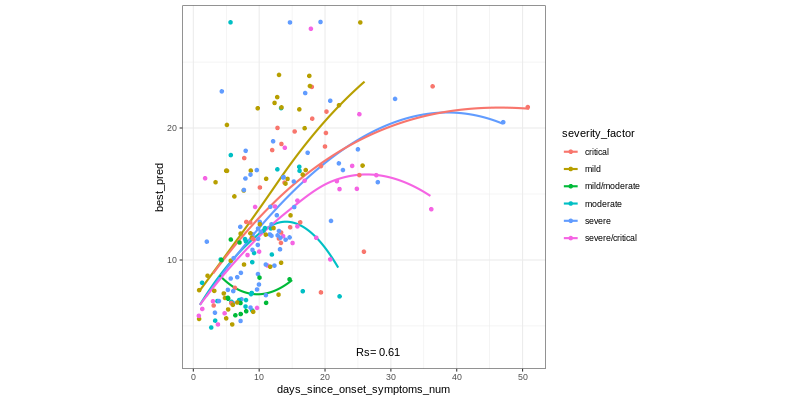

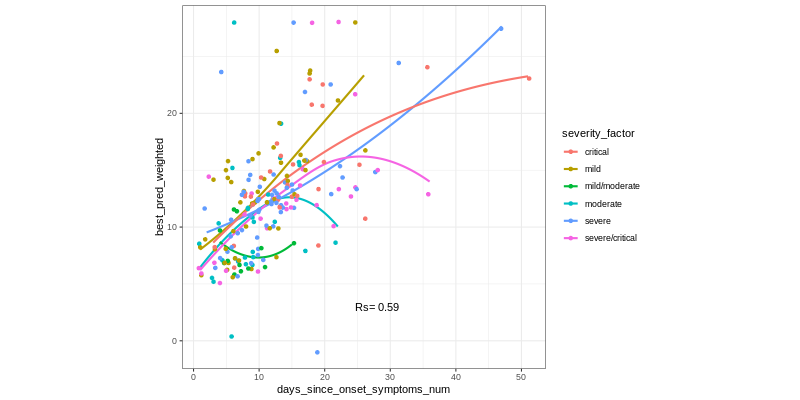

In [39]:
%%R -w 800 -h 400
library(ggplot2)
relevantRows <- predFits$cell_freqs>1000 & floor(predFits$best_pred)>0 & predFits$severity!="asymptomatic" & predFits$disease_status%in%c("convalescence","COVID-19")
relevantRows <- predFits$cell_freqs>1000 & floor(predFits$best_pred)>0 & predFits$severity!="asymptomatic" & predFits$disease_status%in%c("COVID-19")
#relevantRows <- predFits$cell_freqs>1000 & floor(predFits$best_pred)>0 & floor(predFits$best_pred)<28 & predFits$severity!="asymptomatic" & predFits$disease_status=="COVID-19"

print(cor(predFits$days_since_onset_symptoms_num[relevantRows],predFits$best_pred[relevantRows],method="spearman", use = "complete.obs"))
print(ggplot(predFits[relevantRows,],
       aes(days_since_onset_symptoms_num,best_pred,col=severity_factor)) + geom_smooth(se=F,method="loess",span=2) + geom_jitter() + 
        theme_bw() + theme(aspect.ratio=1) + annotate("text", y=3, x=28, label= paste("Rs=",round(cor(predFits$days_since_onset_symptoms_num[relevantRows],predFits$best_pred[relevantRows],method="spearman", use = "complete.obs"),2))))
print(ggplot(predFits[relevantRows,],
       aes(days_since_onset_symptoms_num,best_pred_weighted,col=severity_factor)) + geom_smooth(se=F,method="loess",span=2) + geom_jitter() + 
        theme_bw() + theme(aspect.ratio=1) + annotate("text", y=3, x=28, label= paste("Rs=",round(cor(predFits$days_since_onset_symptoms_num[relevantRows],predFits$best_pred_weighted[relevantRows],method="spearman", use = "complete.obs"),2))))


In [40]:
# Saving pretrained model
#torch.save(model.state_dict(), 'GPR_norm_noNegMll_01_smoothTimeNorm2000_seed1_technicalReplicates.pth')

In [41]:
# For loading the pretrained model
#state_dict = torch.load('GPR_norm_noNegMll_01_smoothTimeNorm2000.pth')
#model = MultitaskGPModel(train_x, train_y, likelihood)
#model.load_state_dict(state_dict)

In [42]:
# Saving output of the prediction to fit data to
#%%R
#head(predFits)
#write.table(predFits,file="predFits.GPR_norm_noNegMll_01_smoothTimeNorm2000_seed1_technicalReplicates.txt",col.names=T,row.names=F,quote=F,sep="\t")
#preds_corrected <- as.data.frame(preds_corrected)
#preds_corrected$days_since_viral_exposure <- as.numeric(train_x)
#write.table(preds_corrected,file="preds_corrected.GPR_norm_noNegMll_01_smoothTimeNorm2000_seed1_technicalReplicates.txt",col.names=T,row.names=F,quote=F,sep="\t")